In [45]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# PINN

$$m\frac{d^2u}{dt^2}+\mu \frac{du}{dt}+ku=0$$

Under damped state when:
$$\delta = \frac{\mu}{2m}<\omega_0 = \sqrt{\frac{k}{m}}$$
Initial conditions:
$u(0)=1$ and $\frac{du}{dt}(0)=0$

The exact solution is given by: $$e^{-\delta t}(2Acos(\phi+\omega t))$$ where $\omega=\sqrt{\omega_0^2-\delta^2}$


In [46]:
def solution(delta, omega_0, t):
    assert delta < omega_0
    omega = np.sqrt(omega_0**2-delta**2)
    phi = np.arctan(-delta/omega)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+omega*t)
    exp = torch.exp(-delta*t)
    return exp*2*A*cos

In [47]:
t = torch.linspace(0,1,100)

In [48]:
# DE params
delta = 2
omega_0 = 20
mu = 2*delta
k = omega_0**2
y = solution(delta, omega_0, t)

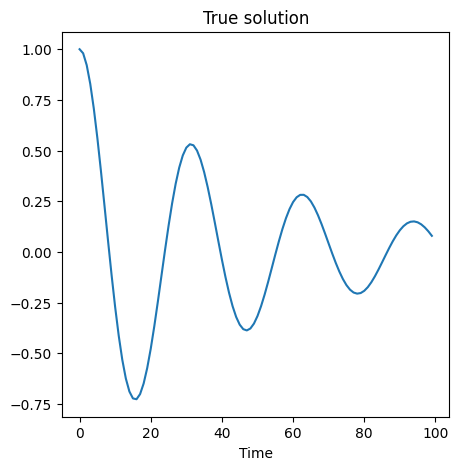

In [49]:
fig, ax = plt.subplots(1, figsize=(5,5))
ax.set_title("True solution")
ax.set_xlabel("Time")
ax.plot(y)

In [73]:
class PINN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super().__init__()
        
        self.layers = nn.ModuleList()
        for hidden in hidden_shapes:
#             print(in_shape, hidden)
            self.layers.append(nn.Linear(in_shape, hidden))
            self.layers.append(nn.Tanh())
            in_shape = hidden
        self.layers.append(nn.Linear(hidden_shapes[-1], out_shape))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

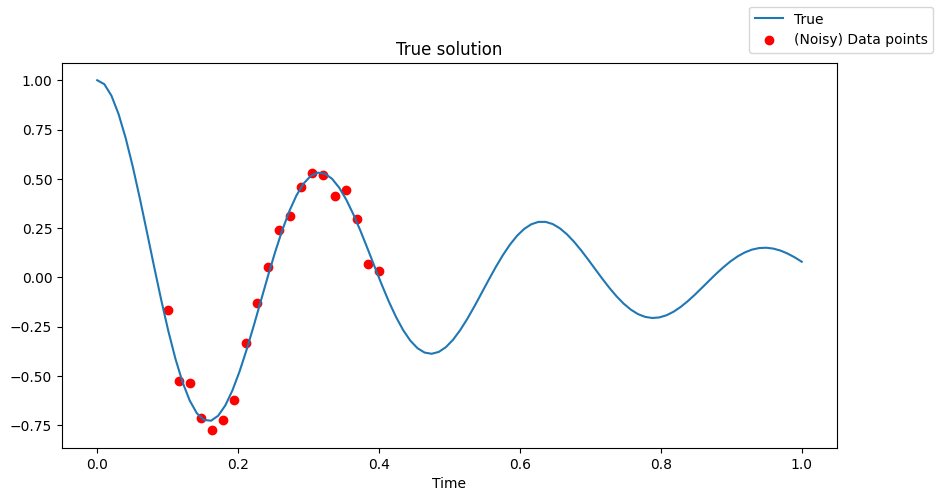

In [131]:
# Data
# Boundary points (Boundary loss)
t_bound = torch.tensor([[0.]]).requires_grad_(True) # allows to compute derivative of NN wrt this input

# Collocation points (Physics loss)
t_physics = torch.linspace(0,1,50).reshape(-1,1).requires_grad_(True)


# For plotting
t_test = torch.linspace(0,1,100)
u_true = solution(delta, omega_0, t_test)

# Noisy points (in a limited range)
t_noisy = torch.linspace(0.1,0.4, 20)
u_noisy = solution(delta, omega_0, t_noisy)
mean, stdev = 0, 0.05
noise = torch.randn_like(u_noisy) * stdev + mean
u_noisy += noise


fig, ax = plt.subplots(1, figsize=(10,5))
ax.set_title("True solution")
ax.set_xlabel("Time")
ax.plot(t_test, u_true, label='True')
ax.scatter(t_noisy, u_noisy, label='(Noisy) Data points', color='r')
fig.legend()

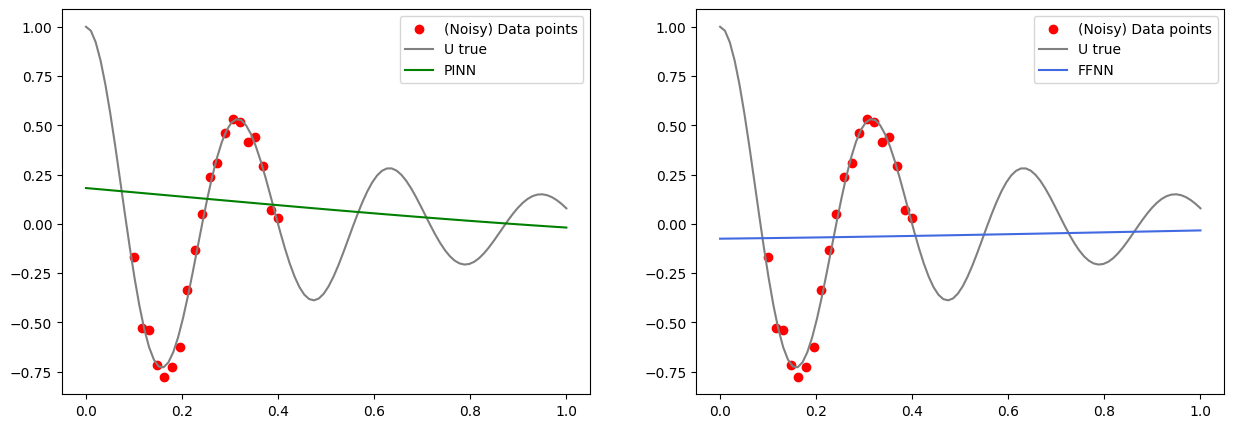

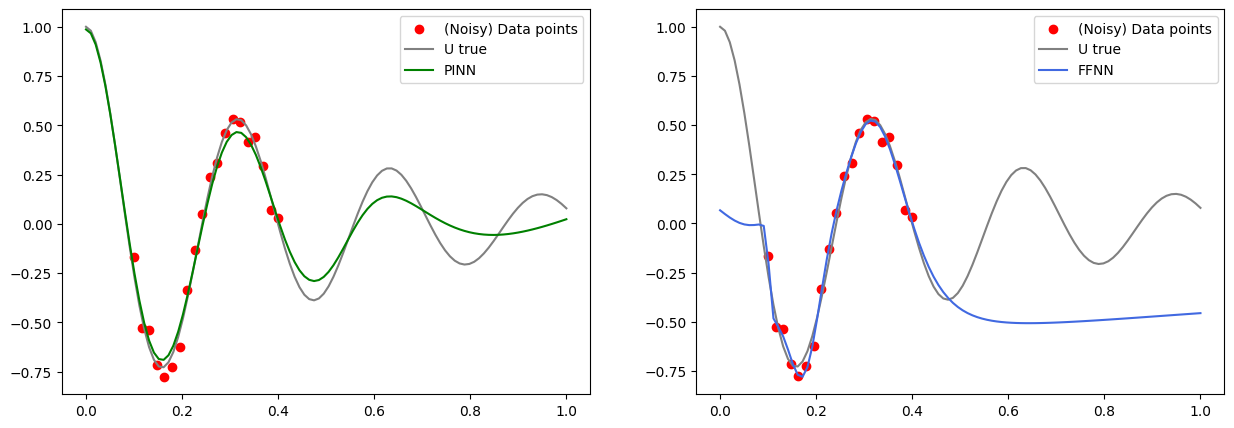

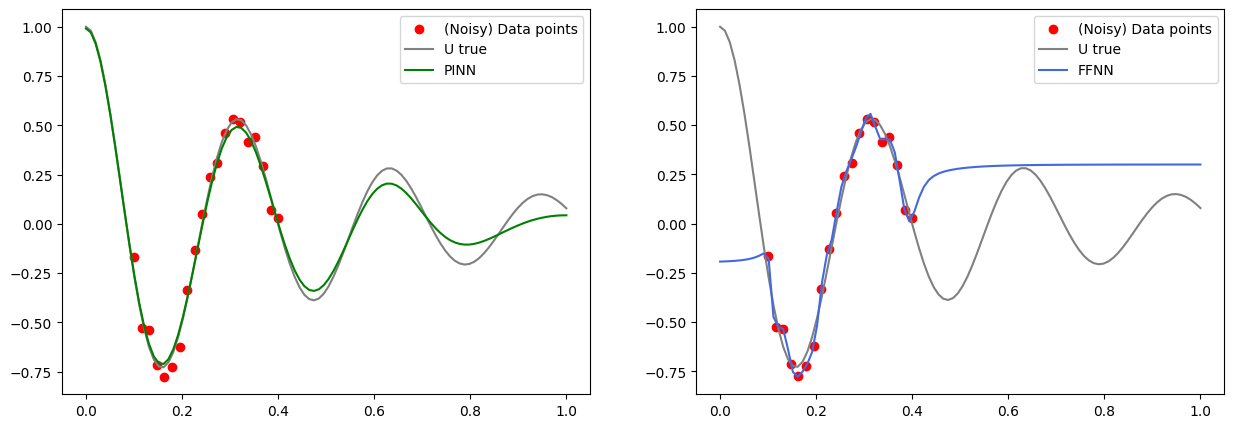

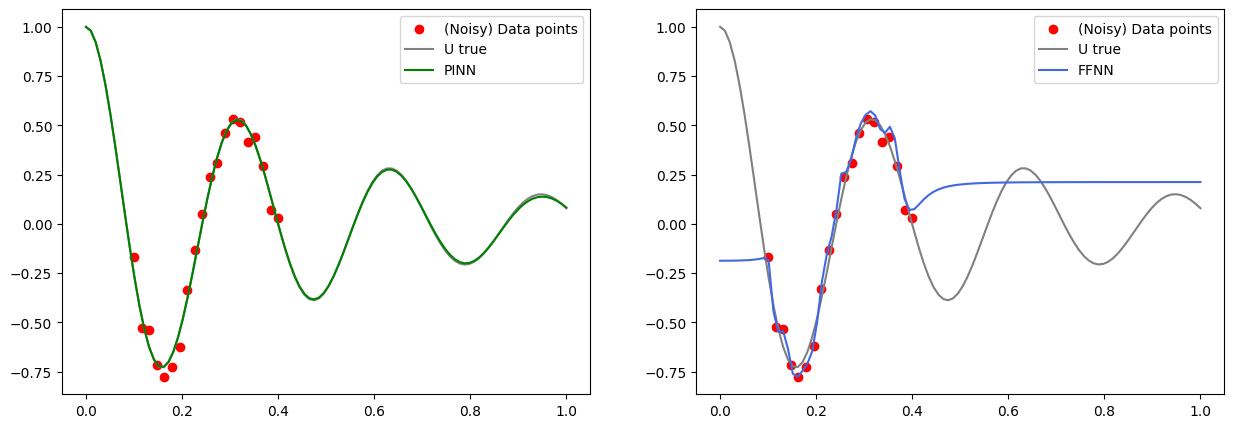

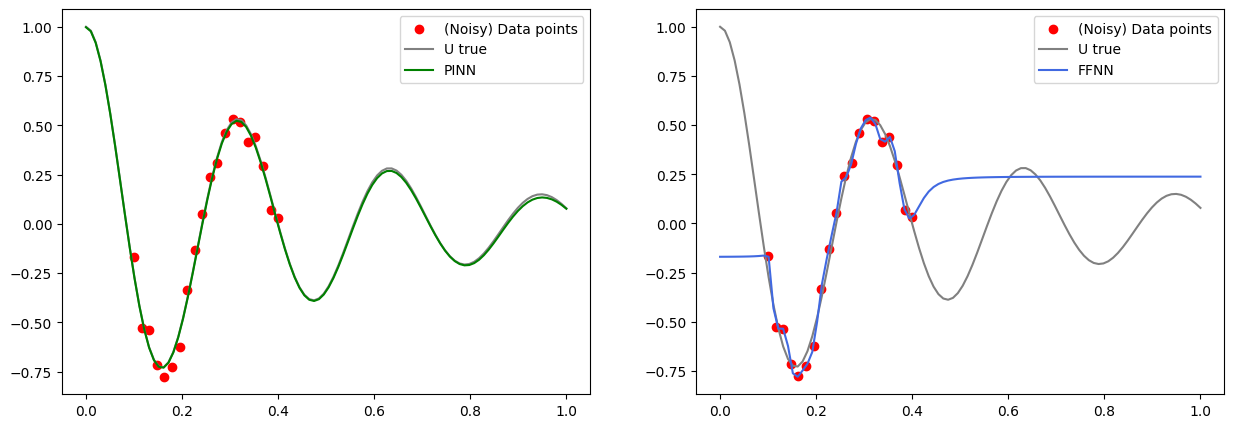

In [176]:
# training loop

# Define a PINN
pinn = PINN(in_shape=1, out_shape=1, hidden_shapes=[32, 32, 32])

# Define a FFNN (same architecture but will use different loss)
ffnn = PINN(in_shape=1, out_shape=1, hidden_shapes=[16,16,16])



lr = 1e-3
optimizer = torch.optim.Adam(pinn.parameters(), lr=lr)
optimizer_ffnn = torch.optim.Adam(ffnn.parameters(), lr=1e-2)

# Give a weight to the various loss components
lambda1, lambda2, lambda3 = 1e-1, 1e-4, 1e-3



iterations = 20001
for i in range(iterations):
    
    # Train FFNN ---
    optimizer_ffnn.zero_grad()
    out = ffnn(t_noisy.reshape(-1,1))
    loss_ffnn = torch.mean((out - u_noisy.reshape(-1,1))**2)
    loss_ffnn.backward()
    optimizer_ffnn.step()
    
    # Train PINN ---
    optimizer.zero_grad()
    
    # boundary loss
    u_b = pinn(t_bound)
    loss1 = (torch.squeeze(u_b)-1)**2 # make sure u(0)=1
    dudt = torch.autograd.grad(u_b, t_bound, torch.ones_like(u_b), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2 # make sure du(0)/dt = 0
    
    # physics loss
    u_p = pinn(t_physics)
    dudt = torch.autograd.grad(u_p, t_physics, torch.ones_like(u_p), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u_p)**2)
    
    # Datapoint loss
    u_n = pinn(t_noisy.reshape(-1,1))
    loss4 = torch.mean((u_n - u_noisy.reshape(-1,1))**2)
    
    loss = loss1 + lambda1*loss2 + lambda2*loss3 + lambda3*loss4
    loss.backward()
    optimizer.step()
    

    
    if i%5000 == 0:
        # plot the results
        with torch.no_grad():
            fig, ax = plt.subplots(1,2, figsize=(15,5))
            ax[0].scatter(t_noisy, u_noisy, label='(Noisy) Data points', color='r') # noisy points
            ax[0].plot(t_test, u_true, label='U true', color='gray') # true function
            ax[1].scatter(t_noisy, u_noisy, label='(Noisy) Data points', color='r') # noisy points
            ax[1].plot(t_test, u_true, label='U true', color='gray') # true function
            
            # pinn
            u = pinn(t_test.reshape(-1,1))
            ax[0].plot(t_test, u, label='PINN', color='g') # PINN predicted
            # ffnn
            out = ffnn(t_test.reshape(-1,1)) # FFNN predicted
            ax[1].plot(t_test, out, label='FFNN', color='royalblue')
            
            ax[0].legend()
            ax[1].legend()
            plt.show()
    